In [1]:
import numpy as np
if not hasattr(np, 'typeDict'):
    np.typeDict = np.sctypeDict
import tensorflow
import matplotlib


print(tensorflow.__version__)
print(np.__version__)
print(matplotlib.__version__)

2025-03-10 21:57:06.475788: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-10 21:57:06.477741: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-10 21:57:06.510799: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-10 21:57:06.511373: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-10 21:57:06.998684: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

2.13.1
1.24.3
3.3.4


## 데이터 정제 및 토큰화
### 데이터 중복 제거

In [2]:
kor_path = "/home/downtown/aiffel/transformer_translate/korean-english-park.train.ko"
eng_path = "/home/downtown/aiffel/transformer_translate/korean-english-park.train.en"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)

    # 중복 제거 (병렬 쌍을 유지해야 하므로 zip 사용)
    unique_pairs = set(zip(kor, eng))

    # 리스트로 변환
    cleaned_corpus = list(unique_pairs)

    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)

### 데이터 전처리 함수

In [3]:
import re

def preprocess_sentence(sentence):
    # 모든 입력을 소문자로 변환
    sentence = sentence.lower()

    # 알파벳, 한글, 문장부호만 남기고 제거 (공백 포함)
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅎ가-힣.,!?]", " ", sentence)

    # 문장부호 양옆에 공백 추가
    sentence = re.sub(r"([.,!?])", r" \1 ", sentence)

    # 여러 개의 공백을 하나의 공백으로 변환
    sentence = re.sub(r"\s+", " ", sentence)

    # 문장 앞뒤의 불필요한 공백 제거
    sentence = sentence.strip()

    return sentence

### 데이터 토큰화

In [5]:
# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.

import sentencepiece as spm
import os

def generate_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):

    # 학습 데이터 저장
    temp_file = f"temp_{lang}.txt"
    with open(temp_file, "w", encoding="utf-8") as f:
        for sentence in corpus:
            f.write(sentence + "\n")

    # SentencePiece 모델 학습
    model_prefix = f"tokenizer_{lang}"
    spm.SentencePieceTrainer.Train(
        input=temp_file,
        model_prefix=model_prefix,
        vocab_size=vocab_size,
        pad_id=pad_id,
        bos_id=bos_id,
        eos_id=eos_id,
        unk_id=unk_id,
        model_type="bpe"  # Byte Pair Encoding 방식 사용
    )

    # 학습된 모델 로드
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(f"{model_prefix}.model")

    # 임시 파일 삭제
    os.remove(temp_file)

    return tokenizer

SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

eng_corpus = []
kor_corpus = []

for pair in cleaned_corpus:
    k, e = pair

    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

True

In [6]:
print(en_tokenizer)  # 모델이 정상 로드되었는지 확인

<sentencepiece.SentencePieceProcessor; proxy of <Swig Object of type 'sentencepiece::SentencePieceProcessor *' at 0x7ff6bcd088a0> >


In [7]:
tokens = en_tokenizer.encode("Hello, how are you?", out_type=int)
decoded_sentence = en_tokenizer.decode(tokens)

print("토큰화 결과:", tokens)
print("디코딩 문장:", decoded_sentence)

토큰화 결과: [1, 19971, 3, 9589, 19993, 578, 154, 461, 3, 2]
디코딩 문장:  ⁇ ello, how are you ⁇ 


In [8]:
print(en_tokenizer.get_piece_size())

20000


In [9]:
# 0~4번 인덱스 토큰 확인
for i in range(5):
    print(f"인덱스 {i}: {en_tokenizer.id_to_piece(i)}")

인덱스 0: <pad>
인덱스 1: <s>
인덱스 2: </s>
인덱스 3: <unk>
인덱스 4: ▁t


In [10]:
indexes = [1, 19971, 3, 9590, 19993, 578, 154, 461, 3, 2]
for i in indexes:
    print(f"인덱스 {i}: {en_tokenizer.id_to_piece(i)}")

인덱스 1: <s>
인덱스 19971: ▁
인덱스 3: <unk>
인덱스 9590: heit
인덱스 19993: ,
인덱스 578: ▁how
인덱스 154: ▁are
인덱스 461: ▁you
인덱스 3: <unk>
인덱스 2: </s>


#### 토크나이저를 활용해 토큰의 길이가 50 이하인 데이터를 선별하여 src_corpus와 tgt_corpus를 각각 구축하고, 텐서 enc_train과 dec_train으로 변환

In [ ]:
import tensorflow as tf
from tqdm.notebook import tqdm    # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm(range(len(kor_corpus))):
    # 한글 문장 토큰화
    src_tokens = ko_tokenizer.EncodeAsIds(kor_corpus[idx])
    # 영어 문장 토큰화 (BOS/EOS 포함)
    tgt_tokens = en_tokenizer.EncodeAsIds(eng_corpus[idx])

    # 길이 제한 (50 이하만 저장)
    if len(src_tokens) <= 50 and len(tgt_tokens) <= 50:
        src_corpus.append(src_tokens)
        tgt_corpus.append(tgt_tokens)

# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post') # ko
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post') # en

  0%|          | 0/78968 [00:00<?, ?it/s]

In [12]:
print(enc_train[:5])
print(dec_train[:5])

[[ 9173  3017  7294 18851     5  1635    39 19476 19366   344     4     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0]
 [ 9275 18947   213    87   527 18957 18937   270  2190  5519  7944 18816
  18449  3490   517 12084    58     4     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0]
 [  106   886  2437   257 17217   839  2916 18861  8336  7941     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0]
 [16352  2565 18842  1443   529  8487  1773  2134   470   389  1266

In [13]:
print(enc_train.shape)
print(dec_train.shape)

(75513, 50)
(75513, 50)


## 모델 설계

In [14]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)


'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [16]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import re
import os
import io
import time
import random

import seaborn # Attention 시각화를 위해 필요!

print(tf.__version__)

2.13.1


### Positional Encoding

In [245]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table


### Multi-Head Attention

In [246]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)


        """
        Scaled QK 값 구하기
        """        
        
        
        if mask is not None: scaled_qk += (mask * -1e9)  
            
        """
        1. Attention Weights 값 구하기 -> attentions
        2. Attention 값을 V에 곱하기 -> out
        """ 
        tf.print("scaled_qk shape:", tf.shape(scaled_qk))

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)
        tf.print("Attention output shape:", tf.shape(out))

        return out, attentions
            

    def split_heads(self, x):
        
        """
        Embedding을 Head의 수로 분할하는 함수

        x: [ batch x length x emb ]
        return: [ batch x heads x length x self.depth ]
        """
        
        batch_size = tf.shape(x)[0]
        seq_len = tf.shape(x)[1]
        split_x = tf.reshape(x, (batch_size, seq_len, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])
        tf.print("split_heads output shape:", tf.shape(split_x))

        return split_x

    def combine_heads(self, x):
        
        """
        분할된 Embedding을 하나로 결합하는 함수

        x: [ batch x heads x length x self.depth ]
        return: [ batch x length x emb ]
        """

        
        batch_size = tf.shape(x)[0]
        seq_len = tf.shape(x)[1]
        x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(x, (batch_size, seq_len, self.d_model))
        tf.print("combine_heads output shape:", tf.shape(combined_x))

        return combined_x

        
    def call(self, Q, K, V, mask):
        
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split)
                 -> out, attention_weights
        Step 4: Combine Heads(out) -> out
        Step 5: Linear_out(out) -> out

        """
        
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
  
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

### Position-wise Feed-Forward Network

In [247]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

### Encoder Layer

In [248]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn


### Decoder Layer

In [249]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, causality_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, padding_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

### Encoder/Decoder Class

In [250]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [251]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

### Transformer

In [252]:
class Transformer(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 src_vocab_size,
                 tgt_vocab_size,
                 pos_len,
                 dropout=0.2,
                 shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.n_heads = n_heads

        """
        1. Embedding Layer 정의
        2. Positional Encoding 정의
        3. Encoder / Decoder 정의
        4. Output Linear 정의
        5. Shared Weights
        6. Dropout 정의
        """
        
        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        """
        입력된 정수 배열을 Embedding + Pos Encoding
        + Shared일 경우 Scaling 작업 포함

        x: [ batch x length ]
        return: [ batch x length x emb ]
        """
        
        seq_len = tf.shape(x)[1]
        tf.print("Embedding input shape:", tf.shape(x))
        tf.print("Sequence length:", seq_len)
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)
        tf.print("Embedding output shape:", tf.shape(out))

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        Step 2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        Step 3: Decoder(dec_in, enc_out, mask)
                -> dec_out, dec_attns, dec_enc_attns
        Step 4: Out Linear(dec_out) -> logits
        """
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

### generate_padding_mask

In [253]:
# import numpy as np
# import tensorflow as tf

# def generate_padding_mask(seq):
#     seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
#     return seq[:, tf.newaxis, tf.newaxis, :]

# def generate_causality_mask(seq):
#     # seq의 shape: (batch_size, seq_len)
#     batch_size = tf.shape(seq)[0]
#     seq_len = tf.shape(seq)[1]
#     # 정방 행렬 (seq_len, seq_len) 생성
#     mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
#     # (1, 1, seq_len, seq_len) 모양으로 확장
#     mask = mask[tf.newaxis, tf.newaxis, :, :]
#     # 배치 차원만큼 타일링하여 (batch_size, 1, seq_len, seq_len) 모양으로 변경
#     mask = tf.tile(mask, [batch_size, 1, 1, 1])
#     return mask

# def generate_masks(src, tgt):
#     enc_mask = generate_padding_mask(src)          # (batch, 1, 1, src_len)
#     causality_mask = generate_causality_mask(tgt)     # (batch, 1, tgt_len, tgt_len)
#     dec_enc_mask = generate_padding_mask(src)         # (batch, 1, 1, src_len)
    
#     tf.print("enc_mask shape:", tf.shape(enc_mask))
#     tf.print("causality_mask shape:", tf.shape(causality_mask))
#     tf.print("dec_mask shape:", tf.shape(dec_enc_mask))

#     return enc_mask, causality_mask, dec_enc_mask

In [254]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(seq_len, batch_size, num_heads):
    # 기본 Look-ahead Mask 생성
    mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)  # (seq_len, seq_len)

    # 4D로 변형 후 batch와 heads 차원에 맞게 타일링
    mask = mask[tf.newaxis, tf.newaxis, :, :]  # (1, 1, seq_len, seq_len)
    mask = tf.tile(mask, [batch_size, num_heads, 1, 1])  # (batch_size, num_heads, seq_len, seq_len)

    return mask


def generate_masks(src, tgt, batch_size=1, num_heads=8):
    enc_padding_mask = generate_padding_mask(src)
    dec_enc_padding_mask = generate_padding_mask(src)

    dec_padding_mask = generate_padding_mask(tgt)

    seq_len = tf.shape(tgt)[1]
    causal_mask = generate_causality_mask(seq_len, batch_size, num_heads)

    # Look-ahead + padding mask 결합
    dec_padding_mask = tf.tile(dec_padding_mask, [1, num_heads, seq_len, 1])
    combined_mask = tf.maximum(dec_padding_mask, causal_mask)

    return enc_padding_mask, combined_mask, dec_enc_padding_mask


## 훈련

In [255]:
transformer = Transformer(
    n_layers = 2,          # Encoder & Decoder Layers
    d_model = 512,         # Embedding 차원
    n_heads = 8,           # Multi-Head Attention에서 Head 수
    d_ff = 2048,           # Feed Forward 네트워크의 Hidden Layer 크기
    src_vocab_size = SRC_VOCAB_SIZE,  # 입력 언어의 Vocabulary 크기
    tgt_vocab_size = TGT_VOCAB_SIZE,  # 출력 언어의 Vocabulary 크기
    pos_len = 100,         # 최대 시퀀스 길이
    dropout = 0.1,         # Dropout 비율
    shared=True  # Embedding Weight 공유 여부
)


### Learning Rate Schedule

In [256]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        # step, d_model, warmup_steps를 float으로 캐스팅
        step = tf.cast(step, tf.float32)
        d_model = tf.cast(self.d_model, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        
        arg1 = tf.math.pow(step, -0.5)
        arg2 = step * tf.math.pow(warmup_steps, -1.5)
        
        return tf.math.pow(d_model, -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)


Text(0.5, 0, 'Train Step')

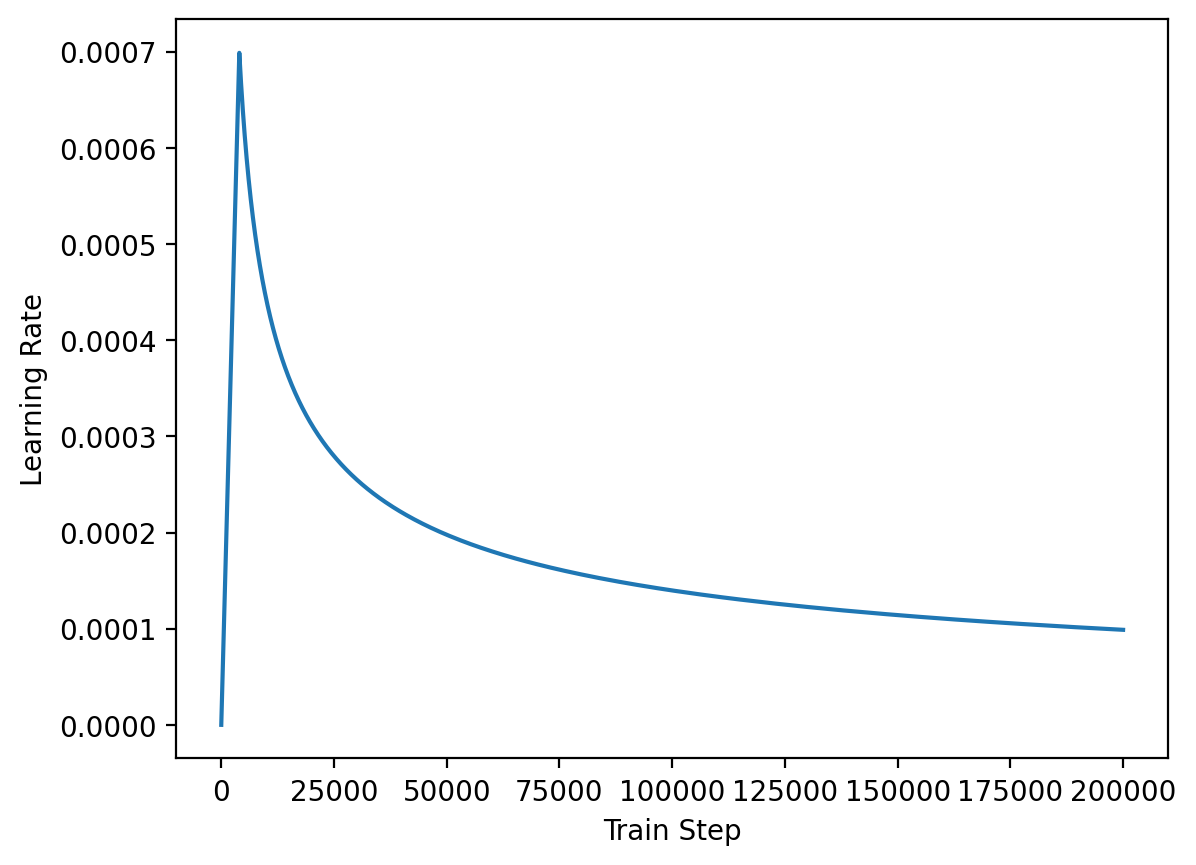

In [257]:
plt.plot(learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### Loss function

In [258]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

### train_step function

In [259]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, causality_mask, dec_mask = generate_masks(src, tgt, batch_size=64, num_heads=8)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, causality_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

### 학습 진행

In [260]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [261]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    tf.print("evaluate _input shape:", tf.shape(_input))
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    tf.print("Initial output shape:", tf.shape(output))

    for i in range(dec_train.shape[-1]):
        batch_size = tf.shape(_input)[0]
        enc_padding_mask, combined_mask, dec_padding_mask = \
            generate_masks(_input, output, batch_size=batch_size, num_heads=model.n_heads)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)
        
        tf.print("Predictions shape:", tf.shape(predictions))

        predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

#         predicted_id = \
#         tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            # break  # EOS가 나오면 종료
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 1)], axis=1)
        tf.print("Updated output shape:", tf.shape(output))

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [262]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=True):
    # 평가 전에 eager 모드 활성화 (훈련에는 영향 주지 않음)
    # transformer.run_eagerly = True
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [ ]:
# 테스트 문장을 이용해 evaluate 함수 실행
# output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

pieces, result, enc_attns, dec_attns, dec_enc_attns = evaluate(
    "오바마는 대통령이다.", transformer, ko_tokenizer, en_tokenizer)


evaluate _input shape: [1 50]
Initial output shape: [1 1]
enc_mask shape: [1 1 1 50]
causality_mask shape: [1 1 1 1]
dec_mask shape: [1 1 1 50]
Embedding input shape: [1 50]
Sequence length: 50
Embedding output shape: [1 50 512]
Embedding input shape: [1 1]
Sequence length: 1
Embedding output shape: [1 1 512]
split_heads output shape: [1 8 50 64]
split_heads output shape: [1 8 50 64]
split_heads output shape: [1 8 50 64]
scaled_qk shape: [1 8 50 50]
Attention output shape: [1 8 50 64]


InvalidArgumentError: Exception encountered when calling layer 'multi_head_attention_42' (type MultiHeadAttention).

{{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input to reshape is a tensor with 25600 values, but the requested shape has 4096 [Op:Reshape]

Call arguments received by layer 'multi_head_attention_42' (type MultiHeadAttention):
  • Q=tf.Tensor(shape=(1, 50, 512), dtype=float32)
  • K=tf.Tensor(shape=(1, 50, 512), dtype=float32)
  • V=tf.Tensor(shape=(1, 50, 512), dtype=float32)
  • mask=tf.Tensor(shape=(1, 1, 1, 50), dtype=float32)

In [172]:
# 테스트 문장을 이용해 evaluate 함수 실행
# output = tf.concat([output, tf.expand_dims([predicted_id], 1)], axis=-1)

pieces, result, enc_attns, dec_attns, dec_enc_attns = evaluate(
    "오바마는 대통령이다.", transformer, ko_tokenizer, en_tokenizer)


evaluate _input shape: [1 50]
Initial output shape: [1 1]
enc_mask shape: [1 1 1 50]
causality_mask shape: [1 1 1 1]
dec_mask shape: [1 1 1 50]
Embedding input shape: [1 50]
Sequence length: 50
Embedding output shape: [1 50 512]
Embedding input shape: [1 1]
Sequence length: 1
Embedding output shape: [1 1 512]
split_heads output shape: [1 8 50 64]
split_heads output shape: [1 8 50 64]
split_heads output shape: [1 8 50 64]
scaled_qk shape: [1 8 50 50]
Attention output shape: [1 8 50 64]


InvalidArgumentError: Exception encountered when calling layer 'multi_head_attention_48' (type MultiHeadAttention).

{{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input to reshape is a tensor with 25600 values, but the requested shape has 4096 [Op:Reshape]

Call arguments received by layer 'multi_head_attention_48' (type MultiHeadAttention):
  • Q=tf.Tensor(shape=(1, 50, 512), dtype=float32)
  • K=tf.Tensor(shape=(1, 50, 512), dtype=float32)
  • V=tf.Tensor(shape=(1, 50, 512), dtype=float32)
  • mask=tf.Tensor(shape=(1, 1, 1, 50), dtype=float32)

In [190]:
# 테스트 문장을 이용해 evaluate 함수 실행
# output = tf.concat([output, tf.expand_dims([predicted_id], 1)], axis=-1)

# 평가 전에 eager 모드 활성화 (평가용)
tf.config.run_functions_eagerly(True)

pieces, result, enc_attns, dec_attns, dec_enc_attns = evaluate(
    "오바마는 대통령이다.", transformer, ko_tokenizer, en_tokenizer)

evaluate _input shape: [1 50]
Initial output shape: [1 1]
Embedding input shape: [1 50]
Sequence length: 50
Embedding output shape: [1 50 512]
Embedding input shape: [1 1]
Sequence length: 1
Embedding output shape: [1 1 512]
split_heads output shape: [1 8 50 64]
split_heads output shape: [1 8 50 64]
split_heads output shape: [1 8 50 64]
scaled_qk shape: [1 8 50 50]
Attention output shape: [1 8 50 64]


InvalidArgumentError: Exception encountered when calling layer 'multi_head_attention_54' (type MultiHeadAttention).

{{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input to reshape is a tensor with 25600 values, but the requested shape has 4096 [Op:Reshape]

Call arguments received by layer 'multi_head_attention_54' (type MultiHeadAttention):
  • Q=tf.Tensor(shape=(1, 50, 512), dtype=float32)
  • K=tf.Tensor(shape=(1, 50, 512), dtype=float32)
  • V=tf.Tensor(shape=(1, 50, 512), dtype=float32)
  • mask=tf.Tensor(shape=(1, 1, 1, 50), dtype=float32)

In [263]:
# 학습

from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 20

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

/tmp/ipykernel_12665/1811356450.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(idx_list)


  0%|          | 0/1180 [00:00<?, ?it/s]

Embedding input shape: [64 50]
Sequence length: 50
Embedding output shape: [64 50 512]
Embedding input shape: [64 50]
Sequence length: 50
Embedding output shape: [64 50 512]
split_heads output shape: [64 8 50 64]
split_heads output shape: [64 8 50 64]
split_heads output shape: [64 8 50 64]
scaled_qk shape: [64 8 50 50]
Attention output shape: [64 8 50 64]


InvalidArgumentError: Exception encountered when calling layer 'multi_head_attention_78' (type MultiHeadAttention).

{{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input to reshape is a tensor with 1638400 values, but the requested shape has 262144 [Op:Reshape]

Call arguments received by layer 'multi_head_attention_78' (type MultiHeadAttention):
  • Q=tf.Tensor(shape=(64, 50, 512), dtype=float32)
  • K=tf.Tensor(shape=(64, 50, 512), dtype=float32)
  • V=tf.Tensor(shape=(64, 50, 512), dtype=float32)
  • mask=tf.Tensor(shape=(64, 1, 1, 50), dtype=float32)

## 회고
일단... 할 수 있는 건 최대한 해봤습니다.   
중간중간 shape 출력하도록 해서 상태도 보고, 테스트 문장으로 시험도 해보고..  
다른 분이 해결에 성공하셨다는 코드를 보고 똑같이 따라도 해봤습니다만,   
똑같은 코드인데 어째서 저는 계속 에러가 뜨는 걸까요.  
뭐가 문제인지 모르겠어요.   
우선 오늘은 너무 졸려서 이만 마무리하지만, 이건 꼭 해결하겠습니다....  